<a href="https://colab.research.google.com/github/KaranSantra/ChaiBachai/blob/test-mask-liquid/Segment_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Thu Dec 26 00:17:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import os
HOME = os.getcwd()
print("HOME:", HOME)
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision==0.23.0
%pip install "ultralytics<=8.3.40"
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights
CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))
import torch
import cv2
import supervision as sv
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)


HOME: /content
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.7/213.7 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.4/727.4 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.5/898.5 kB 17.7 MB/s eta 0:00:00
/content/weights/sam_vit_h_4b8939.pth ; exist: True


In [4]:

mask_generator = SamAutomaticMaskGenerator(sam,
        # points_per_side= 16,
        # points_per_batch = 64,
        # pred_iou_thresh=0.55,
        # stability_score_thresh=0.75,
        # stability_score_offset=1.0,
        # box_nms_thresh = 0.7,
        # crop_n_layers = 0,
        # crop_nms_thresh = 0.7,
        # crop_overlap_ratio = 512 / 1500,
        # crop_n_points_downscale_factor= 1,
        # point_grids = None,
        # min_mask_region_area = 0
                                           )

In [ ]:
from ultralytics import YOLO
def detect_pots(image, conf=0.5, imgsz=256):
    """Detect pots in the image using YOLO model"""
    potModel=YOLO(f"{HOME}/best-pot-detection-yolo11s-6.pt")
    results = potModel(image, save=True, imgsz=imgsz, conf=conf)
    pot_bboxes = []
    for result in results:
        pot_bboxes.extend(result.boxes.xyxy.tolist())
        print(result.boxes.xyxy.tolist())
    return pot_bboxes

In [15]:
!unzip rising-tea-images.zip -d rising-tea-images

Archive:  rising-tea-images.zip
  inflating: rising-tea-images/rest-8.jpg  
  inflating: rising-tea-images/rest-9.jpg  
  inflating: rising-tea-images/rest-15.jpg  
  inflating: rising-tea-images/rest-14.jpg  
  inflating: rising-tea-images/rest-10.jpg  
  inflating: rising-tea-images/rest-11.jpg  
  inflating: rising-tea-images/rest-13.jpg  
  inflating: rising-tea-images/rest-12.jpg  
  inflating: rising-tea-images/rest-7.jpg  
  inflating: rising-tea-images/rest-6.jpg  
  inflating: rising-tea-images/rest-4.jpg  
  inflating: rising-tea-images/rest-5.jpg  
  inflating: rising-tea-images/rest-1.jpg  
  inflating: rising-tea-images/rest-2.jpg  
  inflating: rising-tea-images/rest-3.jpg  


In [47]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))
# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

IS_COLAB = True
import os

IMAGE_NAME = "test-1.jpg"
IMAGE_PATH = f"{HOME}/rising-tea-images/rest-1.jpg"

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [48]:
widget.bboxes

[{'x': 311, 'y': 663, 'width': 0, 'height': 0, 'label': ''},
 {'x': 275, 'y': 541, 'width': 0, 'height': 0, 'label': ''}]

[[311 663]]
[[275 541]]
[[311. 663.]
 [275. 541.]]


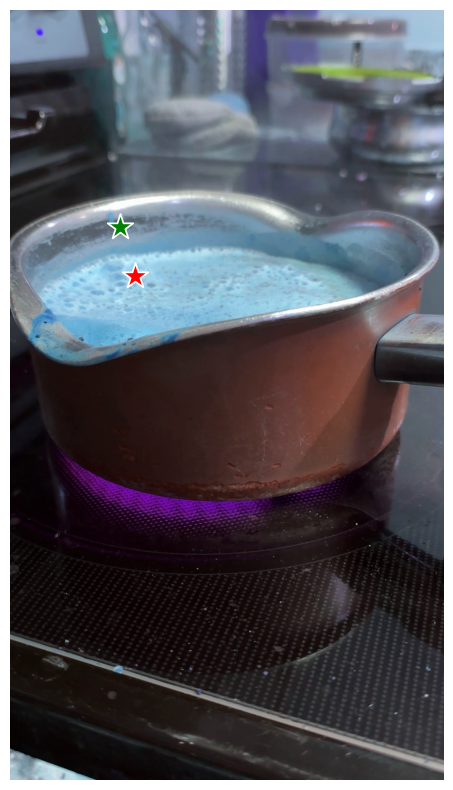

In [55]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from segment_anything import SamPredictor

def create_point_coordinates(bboxes):
    """Convert bounding box coordinates to point array"""
    input_point = np.zeros((0, 2))
    for point in bboxes:
        point_coord = np.array([[point["x"], point["y"]]])
        input_point = np.vstack((input_point, point_coord))
    return input_point

def find_highest_point(mask):
    """Find the point with maximum y-value in the mask
    
    Args:
        mask: Binary mask array
    Returns:
        tuple: (x, y) coordinates of the highest point
    """
    # Get all points where mask is True
    y_coords, x_coords = np.where(mask)
    if len(y_coords) == 0:
        return None
    
    # Find index of maximum y-coordinate
    max_y_idx = np.argmin(y_coords)

    return np.array([[x_coords[max_y_idx], y_coords[max_y_idx]]])

def predict_masks(predictor, image_path, input_point, is_foreground=True):
    """Predict masks using SAM model"""
    # Set input label (1 for foreground, 0 for background)
    input_label = np.array([1, 0]) if is_foreground else np.array([0, 1])
    
    # Load and set image
    image = cv2.imread(image_path)
    predictor.set_image(image)
    
    # Get mask predictions
    masks, scores, _ = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=False
    )
    
    return image, masks

def visualize_masks_with_highest_points(image, fg_masks, bg_masks, input_point, input_label):
    """Visualize masks with their highest points"""
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    
    # Visualize foreground mask (green)
    fg_color = np.array([0/255, 255/255, 0/255, 0.6])
    for mask in fg_masks:
        h, w = mask.shape[-2:]
        mask_image = mask.reshape(h, w, 1) * fg_color.reshape(1, 1, -1)
        plt.gca().imshow(mask_image)
        
        # Find and plot highest point in foreground
        fg_highest = find_highest_point(mask)
        if fg_highest is not None:
            show_points(fg_highest, np.array([1]), plt.gca())
    
    # Visualize background mask (red)
    bg_color = np.array([255/255, 0/255, 0/255, 0.6])
    for mask in bg_masks:
        h, w = mask.shape[-2:]
        mask_image = mask.reshape(h, w, 1) * bg_color.reshape(1, 1, -1)
        plt.gca().imshow(mask_image)
        
        # Find and plot highest point in background
        bg_highest = find_highest_point(mask)
        if bg_highest is not None:
            show_points(bg_highest, np.array([1]), plt.gca())
    
    # Show original input points
    show_points(input_point, input_label, plt.gca())
    plt.axis('off')
    plt.grid(True)
    plt.show()
    
    
    return fg_highest, bg_highest

def main2(sam_model, image_path, bboxes):
    # Initialize predictor
    predictor = SamPredictor(sam_model)
    
    # Get input points from bounding boxes
    input_point = create_point_coordinates(bboxes)
    
    # Generate foreground and background masks
    image, fg_masks = predict_masks(predictor, image_path, input_point, is_foreground=True)
    _, bg_masks = predict_masks(predictor, image_path, input_point, is_foreground=False)
    
    # Visualize masks with highest points
    fg_highest, bg_highest = visualize_masks_with_highest_points(
        image, fg_masks, bg_masks, input_point, np.array([1, 0])
    )
    
    print("Tea level (y-coordinate):", fg_highest[0][1])
    print("Rim level (y-coordinate):", bg_highest[0][1]) 
    difference = bg_highest[0][1]-fg_highest[0][1]
    print("Distance from rim to tea:", difference, "pixels")
    return fg_highest[0][1], bg_highest[0][1]

# Usage:
highest_fg, highest_bg = main2(sam, IMAGE_PATH, widget.bboxes)

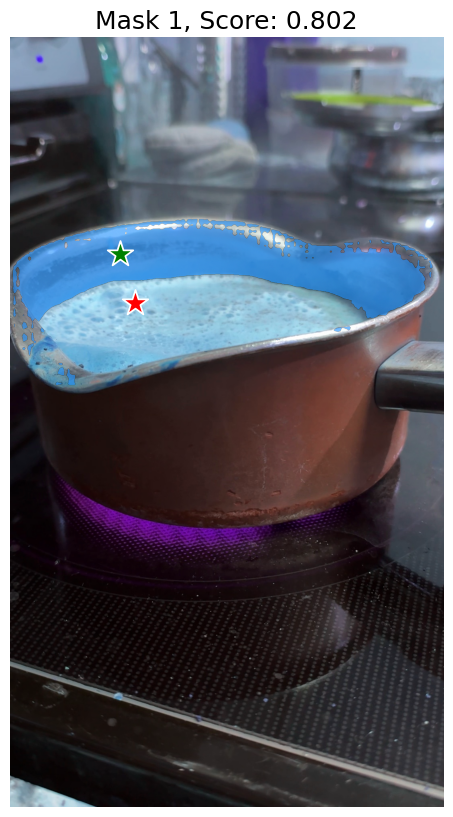

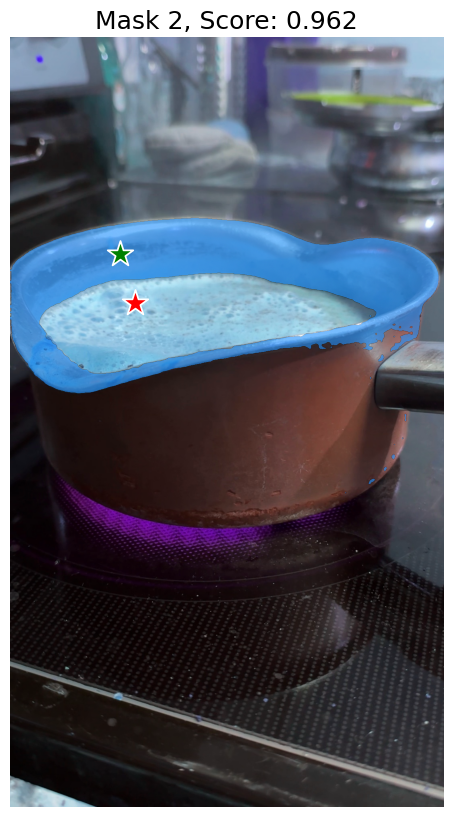

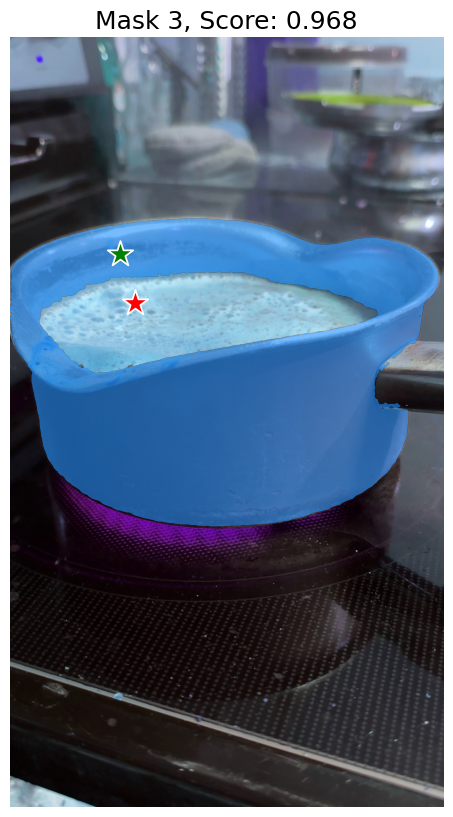

In [56]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()
